# Applied Data Science Capstone

###  - Building a recommendation engine for new business locations -

## Important Info:

It seems GitHub integration of IBM Watson Studio prevents maps and images from being available when looking at the Jupyter notebook on GitHub. Therefore I recommend you to follow this link to the IBM Watson Studio where it should be displayed fine: [https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/d6bb278b-5b58-4154-af22-8da73c1e8d39/view?access_token=d1b2450970a85ad6121e6b19687ea07150ae9df22afe057f12eaa8dc386980d4](https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/d6bb278b-5b58-4154-af22-8da73c1e8d39/view?access_token=d1b2450970a85ad6121e6b19687ea07150ae9df22afe057f12eaa8dc386980d4) 

## Introduction

Starting a new business involves big risks for a company or an entrepreneur. Great manual efforts are necessary to assemble enough information to form a solid decision about potential neighborhoods for the new business location. The complexity of gathering such information often leads to the rough pre-selection of neighborhoods, in order to reduce the workload. This results in potentially promising neighborhoods not being exploited. Such a workload reducing approach even prevents neighborhood (and city) development, once these neighborhoods are generally known as not interesting or too risky for new businesses.

Today's knowledge in data science and the plethora of existing platforms, tools, libraries and APIs empower the construction of a recommendation system for the described problem. By building a recommendation engine, we are able to find the best possible spot for new businesses, even in neighborhoods that would otherwise be disregarded. Using fine grained open data information sources allows us not only to provide recommendations on a coarse neighborhood basis, but even down to the tax lot level. The attracting or repelling influence of points of interest (PoI) can be taken into account when new recommendations are made. The preferences (or objection) towards PoI categories would be used to calculate a vector pulling the recommendation centre away from the neighborhood centroid, towards a more preferable location.

Such a recommendation system not only equalizes the tedious work of manually creating a profile for preferred locations, but picks the best locations from all over the city in only a few seconds, taking large amounts of information into account. Finally, we can even cope for the risk affinity of the entrepreneur by letting him choose all flavours between low risk with high competition, and high risk with low competition at the new business location.

As a proof of concept implementation, we limit the scope of the recommendation engine to the city of New York. This PoC intends to answer the question of whether we can build a recommendation system for new business locations, using the new business' profile, along with additional preferences such as the rental costs, the stakeholders' risk affinity and importance of proximity to a police station. The resulting recommendation engine should be extendable by adding new point of interest categories. 

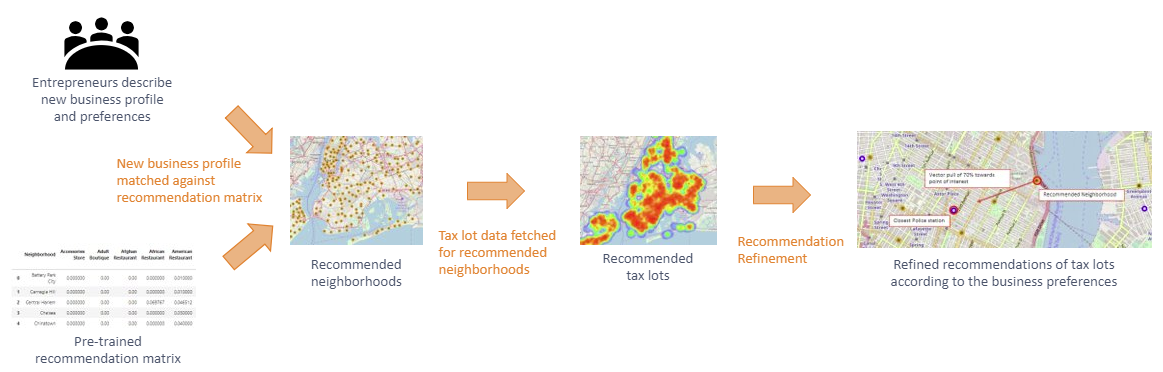

## Data

The goal of this project is to build a recommendation engine that matches the attributes and preferences of a new business against refined data in order to recommend the best spots for new business locations. The recommendation should not only be made on a course neighborhood level, as seen in previous projects, but even on fine grained tax lot level. For the tax lot data level to be meaningful, we need to introduce the attraction/repelling from the neighborhood centroids towards a more preferable location. This attraction or repelling with regards to certain PoI categories will be defined for each user query to the recommendation system. The closest PoI for the defined parameter will then be used to generate a pull towards the new location, where suitable tax lots will be chosen for the recommendation.

For all of the above described requirements, we identified three main data sources for the PoC:

1. [Neighborhood profile matrix from project "Segmenting and Clustering Neighborhoods in New York City"](https://www.coursera.org/learn/applied-data-science-capstone/ungradedLti/f0QY7/segmenting-and-clustering-neighborhoods-in-new-york-city): This data has been used in previous projects of this course series. It consists of NYC neighborhoods (with lat/lon centroids) and their profile defined by the frequency of certain businesses presence in that neighborhood. This data is retrieved by querying the foursquare API for nearby businesses for each neighborhood. 
2. [PLUTO: Extensive land use and geographic data at the tax lot level](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page): The PLUTO dataset has a multitude of information on tax lot level for NYC. It has over 800k records, being tax lots. A subset of the features will be used to identify suitable tax lots in the recommended neighborhood. At the moment it is sufficient to use the location of the tax lot, the value and the area size in order to calculate a value per foot which will be used as a measure for the price segment of the tax lot.
3. [Police stations](https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page): This dataset holds the addresses of all police precincts in NYC, which need to be converted into coordinates for further processing. The location of police stations is important in the sense that they serve as a proof of concept on whether user preferences for police stations will end up in better tax lot recommendations.


#### Future: Recommendation Enhancement through new PoI categories

If the PoC has proven to be successful, it has been shown that the recommendation system can be enhanced in the future to perform even better. This can be achieved by tapping more PoI categories, which results in more preferences being available for each query to the recommendation system. A few examples of future data sources for PoI categories have already been identified:

- [Fire stations](https://data.cityofnewyork.us/widgets/hc8x-tcnd)
- [Hospitals](https://profiles.health.ny.gov/hospital/county_or_region//service:Emergency+Department)
- [Schools](https://data.cityofnewyork.us/Education/2017-2018-School-Locations/p6h4-mpyy)
- [Crime rate](https://data.cityofnewyork.us/Public-Safety/NYC-crime/qb7u-rbmr)

## Methodology
In the first subsection we explore the data for distinct features to solve the research question, before we decide on the methods and models to be orchestrated in subsection 2.

### 1. Data Exploration

#### Import the required packages for data preparation

In [1]:
!conda install -c conda-forge folium=0.5.0 geopy --yes

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
geopy                     1.18.1                     py_0    conda-forge


In [2]:
import math
import numpy as np
import pandas as pd
import json
from collections import namedtuple
from zipfile import ZipFile
import folium
from folium import plugins
from folium.plugins import HeatMap
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from scipy.spatial import KDTree

### 1.1. Neighborhood profile matrix from Foursquare

In [3]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
used_names = set()
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    if neighborhood_name in used_names:
        neighborhood_name = neighborhood_name + ' ('  + borough + ')'
    else:
        used_names.add(neighborhood_name)
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
    len(neighborhoods['Borough'].unique()),
    neighborhoods.shape[0]
))
neighborhoods.head()

The dataframe has 5 boroughs and 306 neighborhoods.


Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [4]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent='my-data-science-project')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='black',
        fill_opacity=0.5,
        parse_html=False).add_to(map_newyork)
    
map_newyork

The geographical coordinate of New York City are 40.7308619, -73.9871558.


#### Define secret Foursquare parameters

In [5]:
# The code was removed by Watson Studio for sharing.

#### Define not so secret Foursquare parameters

In [6]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100

Reuse the code to get nearby venues from the previous projects:

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        try:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)
            
            response = requests.get(url)
            results = response.json()["response"]['groups'][0]['items']
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except KeyError as e:
            print('Failed to fetch', name, ':', response.text)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

There are 430 unique categories.


One hot encode the venue categories to build the profile matrix:

In [9]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

Yoga Studio  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0                  0               0                  0   
1            0                  0               0                  0   
2            0                  0               0                  0   
3            0                  0               0                  0   
4            0                  0               0                  0   

   African Restaurant  Airport Tram  American Restaurant  Animal Shelter  \
0                   0             0                    0               0   
1                   0             0                    0               0   
2                   0             0                    0               0   
3                   0             0                    0               0   
4                   0             0                    0               0   

   Antique Shop  Arcade      ...        Warehouse Store  Waste Facility  \
0             0       0      ...                      0               0   
1             0       0      ...                      0               0   
2             0       0      ...                      0               0   
3             0       0      ...                      0               0   
4             0       0      ...                      0               0   

   Watch Shop  Waterfront  Weight Loss Center  Whisky Bar  Wine Bar  \
0           0           0                   0           0         0   
1           0           0                   0           0         0   
2           0           0                   0           0         0   
3           0           0                   0           0         0   
4           0           0                   0           0         0   

   Wine Shop  Wings Joint  Women's Store  
0          0            0              0  
1          0            0              0  
2          0            0              0  
3          0            0              0  
4          0            0              0  

[5 rows x 430 columns]

Show the head of the grouped neighborhood profiles used in the future for the recommendations:

In [10]:
profiles = onehot.groupby('Neighborhood').mean().reset_index()
profiles.head()

Neighborhood  Yoga Studio  Accessories Store  Adult Boutique  \
0       Allerton          0.0                0.0             0.0   
1       Annadale          0.0                0.0             0.0   
2  Arden Heights          0.0                0.0             0.0   
3      Arlington          0.0                0.0             0.0   
4       Arrochar          0.0                0.0             0.0   

   Afghan Restaurant  African Restaurant  Airport Tram  American Restaurant  \
0                0.0                 0.0           0.0             0.000000   
1                0.0                 0.0           0.0             0.153846   
2                0.0                 0.0           0.0             0.000000   
3                0.0                 0.0           0.0             0.142857   
4                0.0                 0.0           0.0             0.000000   

   Animal Shelter  Antique Shop      ...        Warehouse Store  \
0             0.0           0.0      ...                    0.0   
1             0.0           0.0      ...                    0.0   
2             0.0           0.0      ...                    0.0   
3             0.0           0.0      ...                    0.0   
4             0.0           0.0      ...                    0.0   

   Waste Facility  Watch Shop  Waterfront  Weight Loss Center  Whisky Bar  \
0             0.0         0.0         0.0                 0.0         0.0   
1             0.0         0.0         0.0                 0.0         0.0   
2             0.0         0.0         0.0                 0.0         0.0   
3             0.0         0.0         0.0                 0.0         0.0   
4             0.0         0.0         0.0                 0.0         0.0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  
0       0.0        0.0          0.0            0.0  
1       0.0        0.0          0.0            0.0  
2       0.0        0.0          0.0            0.0  
3       0.0        0.0          0.0            0.0  
4       0.0        0.0          0.0            0.0  

[5 rows x 430 columns]

### 1.2. PLUTO dataset - Tax lot data
The pluto data set contains a lot of information on the tax lot level in NYC. We use this dataset to estimate the cost to either buy or rent a new business location at that tax lot.

First, let's fetch the huge dataset:

In [11]:
!wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1_1_csv.zip

--2018-12-30 22:36:37--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1_1_csv.zip
Resolving www1.nyc.gov (www1.nyc.gov)... 23.207.4.181, 2600:1404:e000:2a0::1500, 2600:1404:e000:2b6::1500
Connecting to www1.nyc.gov (www1.nyc.gov)|23.207.4.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76185085 (73M) [application/zip]
Saving to: ‘nyc_pluto_18v1_1_csv.zip.2’

100%[======================================>] 76,185,085  79.1MB/s   in 0.9s   

2018-12-30 22:36:38 (79.1 MB/s) - ‘nyc_pluto_18v1_1_csv.zip.2’ saved [76185085/76185085]



In [12]:
with ZipFile('nyc_pluto_18v1_1_csv.zip', 'r') as zf:
    zf.extract('dcp_pluto_18v11.csv', '.')

We are basically only interested in the tax lot location, the size and the value, from which we calculate the value per foot of the tax lot:

In [13]:
pluto_columns = ['xcoord', 'ycoord', 'lotarea', 'assesstot']
df_pluto = pd.read_csv('dcp_pluto_18v11.csv', usecols=pluto_columns).dropna()

# Only use the rows which will result in a finite value per foot
df_pluto = df_pluto[df_pluto['lotarea'] > 0]
df_pluto['value_per_foot'] = df_pluto['assesstot'] / df_pluto ['lotarea']

df_pluto.head()

lotarea  assesstot    xcoord    ycoord  value_per_foot
1    32218   72573951  980160.0  200125.0     2252.590198
2    11255    2641050  980389.0  197506.0      234.655709
3     4613     684900  980357.0  197392.0      148.471710
4     1410     820800  982388.0  198261.0      582.127660
5     1455     531450  983352.0  196911.0      365.257732

In [14]:
df_pluto.shape

(833695, 5)

#### Convert NY Long Island coordinate system coordinates into latitude / longitude
The coordinates within the PLUTO dataset are expressed in a [different coordinate system](http://spatialreference.org/ref/epsg/3628/). Hence, we need to convert xcoord and ycoord to latitude and longitude:

In [15]:
# http://spatialreference.org/ref/epsg/3628/
# WGS84 Bounds: -74.2700, 40.4700, -71.7500, 41.3100
# Projected Bounds: 909126.0155, 110626.2880, 1610215.3590, 424498.0529

x_long_min = 909126.0155
x_long_max = 1610215.3590
x_min = -74.2700
x_max = -71.7500

def x_scale(val):
    return (((val - x_long_min) * (x_max - x_min)) / (x_long_max - x_long_min)) + x_min

y_long_min = 110626.2880
y_long_max = 424498.0529
y_min = 40.4700
y_max = 41.3100

def y_scale(val):
    return (((val - y_long_min) * (y_max - y_min)) / (y_long_max - y_long_min)) + y_min

df_pluto['Longitude'] = df_pluto['xcoord'].apply(x_scale).astype(float)
df_pluto['Latitude'] = df_pluto['ycoord'].apply(y_scale).astype(float)
df_pluto.head()

lotarea  assesstot    xcoord    ycoord  value_per_foot  Longitude  \
1    32218   72573951  980160.0  200125.0     2252.590198 -74.014675   
2    11255    2641050  980389.0  197506.0      234.655709 -74.013852   
3     4613     684900  980357.0  197392.0      148.471710 -74.013967   
4     1410     820800  982388.0  198261.0      582.127660 -74.006667   
5     1455     531450  983352.0  196911.0      365.257732 -74.003202   

    Latitude  
1  40.709521  
2  40.702512  
3  40.702207  
4  40.704533  
5  40.700920

Only use a small sample (0.1% of all data) to visualize the coverage. All data (800k records) for data exploration does not make sense and will cause issues.

In [16]:
df_pluto_subset = df_pluto.sample(frac=0.001)

#### Visualize the subset to get an idea of the coverage

In [17]:
map_pluto = folium.Map(location=[40.7128, -74.0060], zoom_start = 11) 

heat_df = df_pluto_subset[['Latitude', 'Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]
HeatMap(heat_data).add_to(map_pluto)
map_pluto

Now we know the tax lot data covers about the same areas as the neighborhood data previously looked at.

#### Investigate the value per foot distribution
We want to categorize the value per foot into about four reasonable categories which correspond from low  to high priced segments.

In [18]:
df_pluto_subset.hist(column='value_per_foot', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b985b46bcc0>]], dtype=object)

We see that there is a huge peak at the beginning and a very long tail.

#### Divide the dataset into 4 price segments and create categories
After playing around with different thresholds we decided on three boundaries between four categories. We chose the three cuts at 10, 25 and 100 value (dollars) per foot, which seemed to result in reasonably sized bags.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b985b932c18>]], dtype=object)

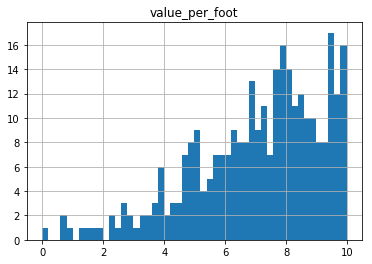

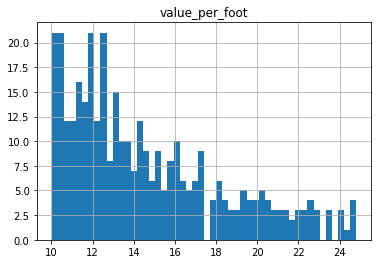

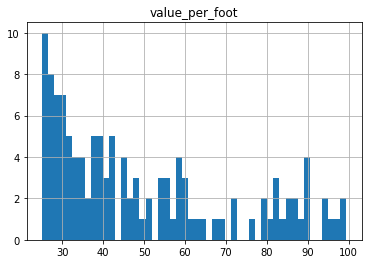

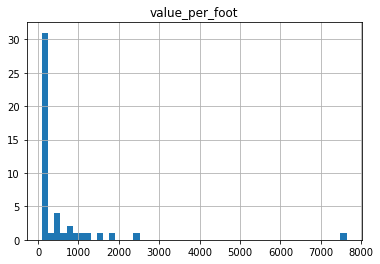

In [19]:
catSmall = 10
catMedium = 25
catBig = 100

df_pluto_subset_small = df_pluto_subset.query('value_per_foot < {}'.format(catSmall))
df_pluto_subset_med = df_pluto_subset.query('value_per_foot >= {} & value_per_foot < {}'.format(catSmall, catMedium))
df_pluto_subset_big = df_pluto_subset.query('value_per_foot >= {} & value_per_foot < {}'.format(catMedium, catBig))
df_pluto_subset_xl = df_pluto_subset.query('value_per_foot >= {}'.format(catBig))

df_pluto_subset_small.hist(column='value_per_foot', bins=50)
df_pluto_subset_med.hist(column='value_per_foot', bins=50)
df_pluto_subset_big.hist(column='value_per_foot', bins=50)
df_pluto_subset_xl.hist(column='value_per_foot', bins=50)

#### Split PLUTO dataset into price categories
Use the previously chosen boundaries to split hte dataset into the desired price segments.

In [20]:
pluto = {
    'price_small': df_pluto.query('value_per_foot < {}'.format(catSmall)),
    'price_medium': df_pluto.query('value_per_foot >= {} & value_per_foot < {}'.format(catSmall, catMedium)),
    'price_big': df_pluto.query('value_per_foot >= {} & value_per_foot < {}'.format(catMedium, catBig)),
    'price_xl': df_pluto.query('value_per_foot >= {}'.format(catBig))
}

### 1.3. Police stations

Police precincts are the proof of concept (PoC) category of points of interest (PoI), to evaluate whether user preferences for some category can give better recommendations of new business locations on a tax lot level. If this PoC is successful, it means the resulting recommendation engine will be incrementally extensible with new PoI categories, allowing gradual enhancements to the system.

### 1.3.1. Scrape the NYPD web page
We extract and cleanse strings indicating the precincts and their addresses so we can later find the coordinates.

In [21]:
url = 'https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page'
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')
table = soup.find('div', class_='about-description').find('table')

precincts = []
addresses = []
for row in table.select('tr'):
    children = row.findChildren(recursive=False)
    
    # only extract the valid rows
    if len(children) > 2 and children[0].name == 'td':
        precincts.append(children[0].get_text().strip())
        addresses.append(children[2].get_text().strip())

df_nypd = pd.DataFrame({ 'precinct': precincts, 'address': addresses })
df_nypd.head()

address      precinct
0    16 Ericsson Place  1st Precinct
1  19 Elizabeth Street  5th Precinct
2   233 West 10 Street  6th Precinct
3   19 1/2 Pitt Street  7th Precinct
4    321 East 5 Street  9th Precinct

### 1.3.2. Retrieve coordinates for precincts
We need to fetch the coordinates for the addresses in order to calculate a vector according to the new business preferences.

In [22]:
geolocator = Nominatim(user_agent='my-data-science-project')

df_nypd = df_nypd.assign(Longitude=np.nan, Latitude=np.nan)
for i, row in df_nypd.iterrows():
    try:
        addr = '{}, New York City'.format(row['address'])
        location = geolocator.geocode(addr, timeout=10)
        if location != None:
            df_nypd.loc[i, 'Longitude'] = location.longitude
            df_nypd.loc[i, 'Latitude'] = location.latitude
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(addr, e.message))

print(df_nypd.shape)
df_nypd.head()

(77, 4)


address      precinct   Latitude  Longitude
0    16 Ericsson Place  1st Precinct        NaN        NaN
1  19 Elizabeth Street  5th Precinct  40.716182 -73.997463
2   233 West 10 Street  6th Precinct        NaN        NaN
3   19 1/2 Pitt Street  7th Precinct  40.716287 -73.983770
4    321 East 5 Street  9th Precinct        NaN        NaN

Some coordinates are missing... either add them manually or drop them!

### 1.3.3. Manually add missing coordinates
This information has a potentially big impact on the recommendation. The manual effort only requires the correction of four records. Therefore we invest this one-time effort to improve the future model.

In [23]:
dt = pd.DataFrame({
    'address': ['16 Ericsson Place', '168-02 P.O Edward Byrne Ave.', '233 West 10 Street', '321 East 5 Street', '2271-89 8th Avenue'],
    'Latitude': [40.7202702, 40.7070813, 40.7342372, 40.7265631, 40.8088575],
    'Longitude': [-74.0093916, -73.7948334, -74.0076419, -73.9900125, -73.9548177]
})
for i, row in dt.iterrows():
    idx = df_nypd.index[df_nypd['address'] == row.address]
    df_nypd.loc[idx, 'Longitude'] = row.Longitude
    df_nypd.loc[idx, 'Latitude'] = row.Latitude

In [24]:
df_nypd.shape

(77, 4)

Check and drop any null columns left. It is crucial that no NaN numbers exist in the dataset to prevent successive errors.

In [25]:
df_nypd[df_nypd.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [address, precinct, Latitude, Longitude]
Index: []

In [26]:
df_nypd.dropna(subset=['Latitude', 'Longitude'])
df_nypd.shape

(77, 4)

### 1.3.4. Display the remaining police precincts alongside the neighborhood centroids
Now that we have the cleansed data for the police precincts, we visualize them as blue dots in the existing NYC map alongside the neighborhood centroids which are represented as orange dots.

In [27]:
def addMarker(row, map_draw):
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        color='blue',
        fill=True,
        fill_color='lightblue',
        fill_opacity=0.7,
        popup=row.precinct + ': ' + row.address
    ).add_to(map_draw)
    
df_nypd.dropna(inplace=True)
df_nypd.apply(lambda row: addMarker(row, map_newyork), axis=1)
map_newyork

In the map above we can see the centroids of the neighborhoods which will be recommended by the system (orange circles). We also see the police stations (blue circles). If the user of the future model decides to define an attraction towards police stations, the closest station to the recommended neighborhood will generate a vectorized pull towards the police station, away from the neighborhood center.

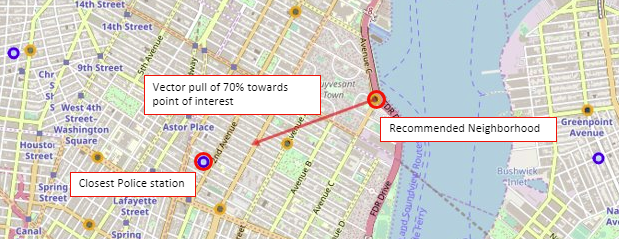

### 1.3.5. PoC Example: Compute & Visualize the pull towards the next police station
Filter for an example neighborhood and the closest example police station:

In [28]:
example_neighborhood = neighborhoods[neighborhoods['Neighborhood'].str.match('Stuyvesant Town')]
example_station = df_nypd[df_nypd['precinct'].str.match('9th Precinct')]

In [29]:
example_neighborhood

Borough     Neighborhood  Latitude  Longitude
275  Manhattan  Stuyvesant Town    40.731 -73.974052

In [30]:
example_station

address      precinct   Latitude  Longitude
4  321 East 5 Street  9th Precinct  40.726563 -73.990013

Define function to calculate bearing between two points. This is used to rotate the arrow head in the arrow direction.

In [31]:
def get_bearing(p1, p2):
    
    '''
    !!! Many thanks to Bob Haffner !!!
    !!! Found on https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e !!!
    
    Returns compass bearing from p1 to p2.
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

Define a function that draws an arrow between two points on the given map:

In [32]:
def draw_arrow(v1, v2, map_draw, size=6):
    norm = np.linalg.norm(v1-v2)
    # go back a bit before drawing since the arrow head is added at the end of the line which would be the precise location
    v2new = v2 - (v2-v1)*norm*size
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    pp1 = Point(v1[0], v1[1])
    pp2 = Point(v2new[0], v2new[1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(pp1, pp2) - 90
    folium.PolyLine(locations=[v1.tolist(), v2.tolist()],
                             opacity=0.7,
                             color='red').add_to(map_draw)
    folium.RegularPolygonMarker(location=pp2, 
        color=None,
        fill_opacity=0.7,
        fill_color='red',
        number_of_sides=3, 
        radius=size,
        rotation=rotation).add_to(map_draw)

Fetch the latitude and longitude of the neighborhhod and the police station. Then simulate that the user finds it 70% important that his new business will be located close to a police station. This is achieved by calculating the new recommended location and visualizing the arrow pulling towards it, closer to the police station.

In [33]:
p1 = example_neighborhood[['Latitude', 'Longitude']].values[0]
p2 = example_station[['Latitude', 'Longitude']].values[0]
importance = 0.7
recommended = p1 + (p2-p1)*importance

In [34]:
draw_arrow(p1, recommended, map_newyork)
map_newyork

Showing this, we have proven that, after a neighborhood has been recommended, it is possible to apply additional preferences for certain categories, which will improve the recommendation system drastically. This gives the engine an extensible nature which leads to even better recommendations, the more point of interest categories are included.

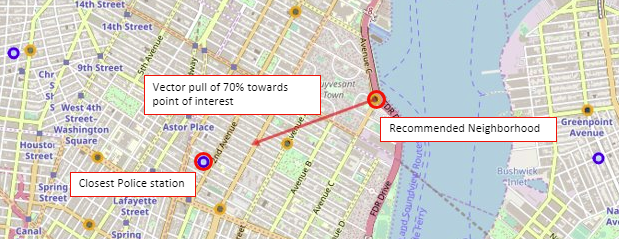

#### 1.3.6. Register the police dataframe in the PoI categories dictionary

In [35]:
pois = { 'Police': df_nypd }

### 2. Methods & Models
Knowing the required data, we can now decide on how to build the recommendation matrix, define input parameters and orchestrate all available parts to find the best recommendation for the users of the system.

### 2.1. User Input
The user who queries the system for a recommendation, needs to define his search parameters. Currently the parameters described below are available.

In [36]:
userInput = {}

#### 2.1.1 Business type
The business type is the type of the new business to be founded. It will be used together with the risk affinity, to identify the best neighborhoods for the new business.

In [37]:
userInput['businessType'] = 'American Restaurant'

#### 2.1.2 Risk affinity
The risk affinity defines how much the entrepreneurs want to risk. If a zero risk affinity is chosen, the neighborhoods with the most similar businesses will be chosen. The downside of this is, it means higher competition. It will be used together with the business type, to identify the best neighborhoods for the new business.

In [38]:
userInput['riskAffinity'] = 0.4

#### 2.1.3 Price segments
Four price segment categories exist `price_small`, `price_medium`, `price_big` & `price_xl`. This attribute will be used to filter the tax lots for the desired price segments.

In [39]:
userInput['priceSegments'] = [ 'price_small', 'price_medium', 'price_big', 'price_xl' ]

#### 2.1.4 Preference for PoIs
A catalogue of PoI preferences in the range of -1 to 1. This will be used to move the recommendation centroids towards a more preferred location for the new business.

In [40]:
userInput['preferencesForPoIs'] = { 'Police': 0.7 }

#### 2.1.5 Number of neighborhoods
Defines, how many neighborhoods should be recommended.

In [41]:
userInput['numNeighborhoods'] = 4

#### 2.1.6 Number of tax lots per neighborhood
The number of recommended tax lots per recommended neighborhood.

In [42]:
userInput['perNeighborhood'] = 3

### 2.2. Risk Adjusted neighborhoods
The first component of the PoC will be the choice of neighborhoods, based on the risk affinity of the stakeholders.
We cope for this by sorting the neighborhoods based on the business type and then select a subset of neighborhoods according to the risk affinity.

There is a big chance that some neighborhoods do not have even one business of the new to be founded business type. We need to pick the right neighborhoods depending on the risk affinity. For example, if the risk affinity is above 90%, we should randomly choose neighborhoods among the ones that do not yet have such a business present.
Also, if the risk affinity is low and less than `numNeighborhoods` would have at least one such business, we need to fill the gap with random picks from neighborhoods that do not have such a business.

In [43]:
bt = userInput['businessType']
ra = userInput['riskAffinity']
nn = userInput['numNeighborhoods']

# We have to limit the number of neighborhoods
if nn > len(profiles):
    print('So many neighborhoods do not even exist!')
    nn = len(profiles)

print('Looking for {}x {}, with risk affinity {}%'.format(nn, bt, ra*100))

picks = profiles[profiles[bt] > 0] # at least one business of the given type exists in the neighborhood
nopicks = profiles[profiles[bt] <= 0] # no business of the given type exists in the neighborhood

# we need to ensure we pick the right neighborhoods. This is tedious and not necessarily beautiful...:
if ra < 0.9:
    if len(picks) < nn:
        # If there are not enough picks, we need to randomly add from the nopicks
        picks = pd.concat([picks, nopicks.sample(n=(nn-len(picks)))])
        
    else:
        # we select a subset around the desired risk affinity. use iloc
        n = len(picks)
        i = int(n * ra - nn/2) # around this index we look for neighborhoods

        # make sure we pick a valid range:
        i = 0 if i < 0 else i
        i = i if i + nn <= len(picks) else len(picks) - nn - 1
        
        picks = picks.sort_values(by=[bt], ascending=False).iloc[i:i+nn]
        
else:
    # with risk affinity above 90% we go for the neighborhoods where no such business exists
    if len(nopicks) < nn:
        # if there are not enough, we pick from the start of the ascending sorted dataframe
        picks = profiles.sort_values(by=[bt])[0:nn]
        
    else:
        # There is enough nopicks around, so we sample randomly
        picks = nopicks.sample(n=nn)

# fetch the desired neighborhoods from the neighborhood dataframe containing the coordinates of the neighborhood centroids
picks = neighborhoods[neighborhoods['Neighborhood'].isin(picks['Neighborhood'].tolist())]
picks.head()

Looking for 4x American Restaurant, with risk affinity 40.0%


Borough      Neighborhood   Latitude  Longitude
59    Brooklyn  Prospect Heights  40.676822 -73.964859
67    Brooklyn          Red Hook  40.676253 -74.012759
94    Brooklyn        Georgetown  40.623845 -73.916075
116  Manhattan           Chelsea  40.744035 -74.003116

### 2.3. Adjust recommendation centeroids
The recommended neighborhoods do have a centroid defined, which would be the basis to find the closest tax lots.
But since we have additional points of interest (PoI) available, we are able to pull the recommendation center away from the neighborhood centroid, towards a more meaningful location.

First, we have to fetch the closest PoI per recommended neighborhood and per the users predefined PoI categories.

In [44]:
def fetchClosestPoI(df, lat_long):
    dists = df.apply(lambda row: np.linalg.norm(lat_long-row[['Latitude', 'Longitude']].values), axis=1)
    return df.iloc[dists.idxmin()]

We iterate through all recommended neighborhoods and adjust the recommendation point towards the more preferrable location.

In [45]:
upf_pois = userInput['preferencesForPoIs']

# Add new columns for the recommendation centroid
picks = picks.assign(recLatitude=picks.Latitude)
picks = picks.assign(recLongitude=picks.Longitude)

for i, row in picks.iterrows():
    init_point = row[['Latitude', 'Longitude']].values
    rec_point = row[['recLatitude', 'recLongitude']].values

    for poi in upf_pois:
        weight = upf_pois[poi]
        poi_record = fetchClosestPoI(pois[poi], init_point)
        p2 = poi_record[['Latitude', 'Longitude']].values
        rec_point += (p2-init_point) * weight
    
    picks.loc[i, 'recLatitude'] = rec_point[0]
    picks.loc[i, 'recLongitude'] = rec_point[1]

print(picks.shape)
picks.head()

(4, 6)


Borough      Neighborhood   Latitude  Longitude  recLatitude  \
59    Brooklyn  Prospect Heights  40.676822 -73.964859    40.679682   
67    Brooklyn          Red Hook  40.676253 -74.012759    40.681564   
94    Brooklyn        Georgetown  40.623845 -73.916075    40.626727   
116  Manhattan           Chelsea  40.744035 -74.003116    40.743099   

     recLongitude  
59     -73.971381  
67     -74.003963  
94     -73.933947  
116    -73.999990

Now let's have a look at the recommended neighborhoods and the adjusted recommendation centroids.

In [46]:
map_rec = folium.Map(location=[40.7308619, -73.9871558], zoom_start=10)
# add all precincts
df_nypd.apply(lambda row: addMarker(row, map_rec), axis=1)
for i, row in picks.iterrows():
    init_point = row[['Latitude', 'Longitude']].values
    rec_point = row[['recLatitude', 'recLongitude']].values
    folium.CircleMarker(
        init_point,
        radius=5,
        color='orange',
        fill=True,
        fill_color='black',
        fill_opacity=0.5,
        popup=row.Neighborhood,
        parse_html=False).add_to(map_rec)
    folium.CircleMarker(
        rec_point,
        radius=5,
        color='red',
        fill=True,
        fill_color='black',
        fill_opacity=0.5,
        popup='Recommendation centroid for '+row.Neighborhood,
        parse_html=False).add_to(map_rec)
    draw_arrow(init_point, rec_point, map_rec)
map_rec

### 2.4. Prepare the KDTree for fast nearest tax lot neighbor lookups
Prepare the filtering of the tax lots for the desired cost category. Choose the tax lots closest to the recommendation centroids.

Since there are over 800k records in the pluto data set, we need to use a tree structure to find the nearest tax lot neighbors of any given recommendation point. Loading all four price categories into KDTrees reduces query time drastically.

In [47]:
kdtrees = {}

for cat, df in pluto.items():
    pts = df[['Longitude', 'Latitude']].values
    kdtrees[cat] = KDTree(pts)

## Results

#### Query prepared KDTrees & Visualize example results

Now that all pieces of the recommendation engine are in place, we can query the KDTrees for the closest tax lot neighbors of the recommendation centroids.

In [48]:
tlpn = userInput['perNeighborhood']
ps = userInput['priceSegments']

colors = {
    'price_small': '#00C601',
    'price_medium': '#BBD200',
    'price_big': '#D96E00',
    'price_xl': '#E10014'
}

for cat in ps:
    res = kdtrees[cat].query(picks[['recLongitude', 'recLatitude']].values, k=tlpn)
    idxs = res[1]
    # res [1] holds the indexes
    for nhs in res[1]:
        # for all nearest neighbors that were found
        for nn in nhs:
            # Fetch the row from the pluto dataset
            row = pluto[cat].iloc[nn]
    
            folium.CircleMarker(
                row[['Latitude', 'Longitude']].values,
                radius=2,
                color=colors[cat],
                parse_html=False).add_to(map_rec)
    
map_rec

The map above demonstrates the outcome of this project:

- The police precincts are outlined as **blue circles with light filling**
- The recommended neighborhoods are outlined as **orange circles with dark filling**
- The adjusted recommendation centroids (according to the user query preferences) are outlined as **red circles with dark filling**
- The **red arrows** demonstrate the recommendation centroids adjustments away from the neighorhood centroids towards the points of interest
- Recommended tax lots are outlined as **small solid circles**, colored with respect to their price category:
    - `price_small`: green
    - `price_medium`: light green
    - `price_big`: orange
    - `price_xl`: red
    
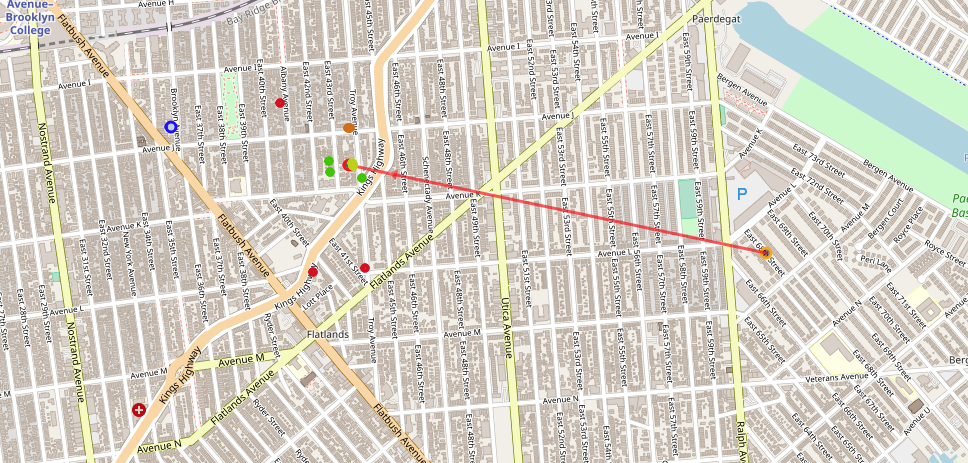

This project succeeded in producing a recommendation system that produces a parameterized number of tax lot recommendations which seem suitable for the founding of a new business. The resulting tax lot recommendations are clearly centered around the adjusted neighborhood centroids, which underlines the capability of the engine to take user preferences for certain points of interest into account. Moreover, the recommendation engine is capable to select intelligent tax lot recommendations from over 800k tax lots in only a few seconds. By doing so it takes several query attributes into account, such as risk affinity, attraction to points of interest, desired price categories and how big the result set should be.

## Discussion

We have demonstrated how a recommendation engine for new business locations can be built using foursquare business location data, tax lot data and precinct data for New York city. The foursquare data was used to build neighborhood profiles which are then used to identify suitable neighborhoods with respect of the entrepreneurs risk affinity. Police precinct locations are used to generate more accurate recommendation centroids, according to the user preferences for points of interest. A consequence of this proof is, that the system can be enhanced with more points of interest categories in the future, leading to a more rich recommendation engine. The fast execution time on the KDTrees demonstrates how the use of the proper methods and models allows to assemble a performant system even in the presence of a large amount of data while only having small computational resources available. This looks promising when it comes to enahnce the system in the future with even more data.

Future work to improve the recommendation engine are listed in the remaining subsections.

### Value per foot

The calculated value per foot might not be an accurate representation of to be expected rental prices. Further research has to prove whether the calculation makes sense in the real world. One major impact on this calculation could be the number of floors on the tax lots. Currently the value of the tax lot is divided by the area. It is likely that the number of floors built on the tax lot has an impact on the value in a way such that the higher the high rise, the higher the value. A compensation for this could be to calculate a value per foot per floor.

### Tax Lot Coordinate Accuracy

As depicted in the figure below, the coordinates of some recommended tax lots seem to be quite accurate (left side of the figure), while in other cases the locations do not make much sense (right side of the figure). This requires further investigation as to what the reason behind this could be. Potentially there is a transform error between the coordinate system used in the pluto data set and the longitude/latitude coordinates.

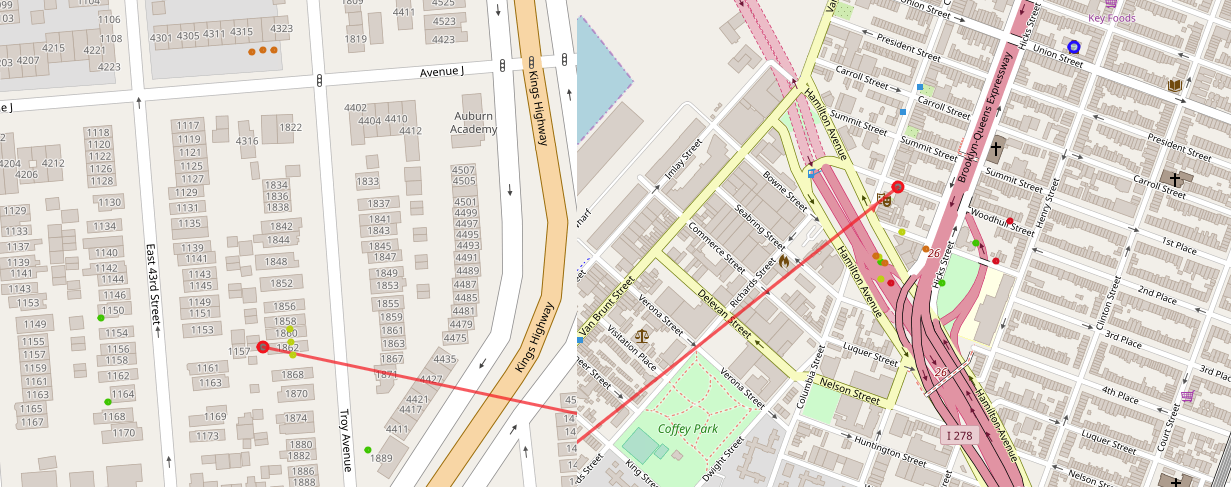

### Recommendation Matrix & Business Affinity

Currently the recommendation matrix is only used in a one-dimensional way. The frequency of the to-be founded type of business is the only feature that matters for the recommendation. A *real* recommendation engine should take many dimensions into account. This is at least where a recommendation matrix really makes sense as it is able to solve complex calculations across several features. However, it does its magic for our use-case.

In the future, a more complex application of the recommendation engine could be in a way such that the user will be able to define the importance of other type of businesses being located nearby. This preference profile could then be used to query the recommendation matrix in a multi-dimensional fashion. This would lead to n even better recommendation engine.

### More Points of Interest Categories

It has been shown that the recommendation system can be enhanced with more PoI categories in the future, to perform even better. Tapping more PoI categories, will allow the user query to define more PoI preferences which will result in more useful recommendations. A few examples of future data sources for PoI categories have already been identified:

- [Fire stations](https://data.cityofnewyork.us/widgets/hc8x-tcnd)
- [Hospitals](https://profiles.health.ny.gov/hospital/county_or_region//service:Emergency+Department)
- [Schools](https://data.cityofnewyork.us/Education/2017-2018-School-Locations/p6h4-mpyy)
- [Crime rates](https://data.cityofnewyork.us/Public-Safety/NYC-crime/qb7u-rbmr)

## Conclusion

The research question of this project is whether we can build a recommendation system for new business locations, using the new business' profile, along with additional preferences such as the rental costs, the stakeholders' risk affinity and importance of proximity to a police station.

We have proven that it is possible to construct such a recommendation system in a straight-forward way. A major advantage for this project was the availablilty of open data to tackle the challenge. We have shown how a user query containing many configurations, produces unique query related results to provide the best tax lot recommendations for the new business location in a timely fashion. Moreover the additional desired attribute of such a system would be the extension by new point of interest categories, which we have proven to be possible as well.

This PoC is limited to NYC data, the existance of data sources for other cities depends vastly from city to city. However, in the age of increasingly available open data, we are positive that it will become continuously easier to port this PoC to other cities.

Future work could include the validation or improvement of the value per foot calculation, the coordinate accuracy of the tax lots, the introduction of business affinities towards other business types for the new businees and also the introduction of new point of interest categories.